# Fig. 3

**Author**: laquitainesteeve@gmail using codes from Carlo Paris and Matthew Chalk

**Description**: Compare SSI for tuning curve and tuning curve x gain of 7

**Execution time**: 2 min

## Setup 

Setup "_fisher_info_limits2_" virtual environment

```python
python -m ipykernel install --user --name fisher_info_limits2 --display-name "fisher_info_limits2"
```

In [ ]:
%%time
%load_ext autoreload
%autoreload 2

# import packages
import os 
from matplotlib import pyplot as plt;
import scipy.io as sio
import numpy as np
from numpy import log
import math
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

# set project path
proj_path = '/home/steeve/steeve/idv/code/fisher-info-limits'
os.chdir(proj_path)

# import custom package
from src import nodes

# setup ilocal parmaeters
SEED = 10
ngamma = 100     # default=100;
gamma0 = 0.01
gamma_max = 200
eta = 1e-4
ny = 101         # discretisation of y = x + sqrt(gamma)*noise. Adapt depending on gamma and tuning curve discretization.
AMP = 20         # max possible spike count
NUM_X = 100      # number of points along each axis in the latent space grid
MAX_X = 10       # max value of PC1 and PC2 axes

# setup the data paths of four examples cells
# nonlinear strong firing
CELL_DATA_PATH_CELL4 = 'data/contrast_cells/carlo_data_cellno82.mat'       # cell responses and image principal components
METRICS_DATA_PATH_CELL4 = 'data/computed_contrast_cells/BDEvSSI_no82.npz'  # precomputed information metrics

# setup figure paraleters
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 8
plt.rcParams["lines.linewidth"] = 0.5
plt.rcParams["axes.linewidth"] = 0.5
plt.rcParams["axes.spines.top"] = False
plt.rcParams["xtick.major.width"] = 0.5 
plt.rcParams["xtick.minor.width"] = 0.5 
plt.rcParams["ytick.major.width"] = 0.5 
plt.rcParams["ytick.minor.width"] = 0.5
plt.rcParams["xtick.major.size"] = 3.5 * 1.1
plt.rcParams["xtick.minor.size"] = 2 * 1.1
plt.rcParams["ytick.major.size"] = 3.5 * 1.1
plt.rcParams["ytick.minor.size"] = 2 * 1.1

CPU times: user 3.43 s, sys: 154 ms, total: 3.59 s
Wall time: 1.08 s


## Functions

## Load dataset

In [2]:
%%time

np.random.seed(SEED)

# load the data and parameters of the image prior for cell 4
pcs_cell4, fit_cell4, mu0_cell4, mu1_cell4, sigma_cell4  = nodes.load_cell_data(CELL_DATA_PATH_CELL4)

# all prior means are near 0, so we set the prior means to (0,0) for all cells
print("prior mean cell 4:", (mu0_cell4, mu1_cell4))

prior mean cell 4: (np.float64(-4.2708990760651386e-17), np.float64(5.3948198855559645e-17))
CPU times: user 866 ms, sys: 113 ms, total: 979 ms
Wall time: 980 ms


## Model tuning curves

In [6]:
%%time

# setup the image latent space
pc_values = np.linspace(-MAX_X, MAX_X, NUM_X) # the values each axis (PC1 and PC2) can take

# train a neural net to predict cells responses in that latent space
_, tuning_curve_model_cell4, _, grid_x, grid_y, _, latent_space = nodes.nnet_fit(pcs_cell4[:2], fit_cell4, linspace=pc_values)

Epoch 1/200, Train Loss: 3.8455, Val Loss: 4.7267
Epoch 20/200, Train Loss: 1.9449, Val Loss: 2.5928
Epoch 40/200, Train Loss: 1.3922, Val Loss: 1.8268
Epoch 60/200, Train Loss: 1.0845, Val Loss: 1.4968
Epoch 80/200, Train Loss: 0.8584, Val Loss: 1.2416
Epoch 100/200, Train Loss: 0.7069, Val Loss: 1.0813
Epoch 120/200, Train Loss: 0.6104, Val Loss: 0.9617
Epoch 140/200, Train Loss: 0.5395, Val Loss: 0.8702
Epoch 160/200, Train Loss: 0.4817, Val Loss: 0.7975
Epoch 180/200, Train Loss: 0.4326, Val Loss: 0.7369
Epoch 200/200, Train Loss: 0.3920, Val Loss: 0.6859
CPU times: user 4.9 s, sys: 16.2 ms, total: 4.91 s
Wall time: 210 ms


## Compute SSI

Execution time: 0.3 secs

In [18]:
%%time 

# cell 4 original
rate_preds_cell4_original = nodes.tuning_curve_nnet(latent_space, tuning_curve_model_cell4).reshape(NUM_X, NUM_X)
ssi_cell4_original, Inf_ssi_cell4_original = nodes.compute_ssi(latent_space, rate_preds_cell4_original, amp=AMP * 7, Sigmax=sigma_cell4)[:2]

# cell firing rate X 7
rate_preds_cell4_x_7 = nodes.tuning_curve_nnet(latent_space, tuning_curve_model_cell4).reshape(NUM_X, NUM_X)
rate_preds_cell4_x_7 *= 7
ssi_cell4_x_7, Inf_ssi_cell4_x_7 = nodes.compute_ssi(latent_space, rate_preds_cell4_x_7, amp=AMP * 7, Sigmax=sigma_cell4)[:2]

CPU times: user 2.88 s, sys: 27.3 ms, total: 2.91 s
Wall time: 144 ms


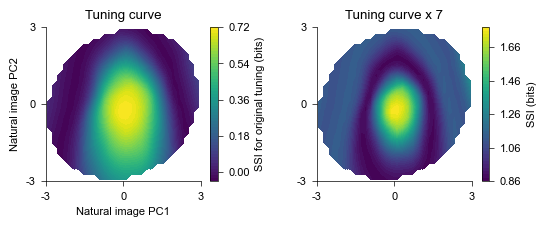

In [19]:
# set figure parameters
letter_size = 20
letter_x = -0.5
letter_y = 2
xylim = (-3,3)
xyticks = (-3,0, 3)

fig, ax = plt.subplots(1, 2, figsize=(6,2))

# calculate the mean coordinates of the Gaussian prior
mu0 = pcs_cell4[0].mean()
mu1 = pcs_cell4[1].mean()

# Create mask for 3 standard deviations
mask_3std = nodes.create_gaussian_mask(grid_x, grid_y, np.array([mu0, mu1]), sigma_cell4, n_std=3)



# First subplot: plot SSI original (MASKED - white outside 3 std) ----------------------------------------------------

# Apply mask to data
preds_masked_original = np.where(mask_3std, rate_preds_cell4_original.reshape(grid_x.shape), np.nan)
ssi_masked_original = np.where(mask_3std, ssi_cell4_original, np.nan)

# plot
im = ax[0].contourf(grid_x, grid_y, ssi_masked_original/log(2), levels=50, cmap='viridis', extend='neither')

# formatting
ax[0].set_facecolor('white')  # Set background to white for masked regions
ax[0].set_xlim(xylim)
ax[0].set_ylim(xylim)
ax[0].set_xticks(xyticks,xyticks)
ax[0].set_yticks(xyticks,xyticks)
ax[0].spines['right'].set_visible(False)
ax[0].set_title("Tuning curve")
ax[0].set_xlabel('Natural image PC1')
ax[0].set_ylabel('Natural image PC2')

# colorbar
cbar = plt.colorbar(im, label='SSI for original tuning (bits)')
ticks = cbar.get_ticks()
cbar.set_ticks(ticks[::2])



# Second subplot: plot SSI for firing rate X 7 (MASKED - white outside 3 std) ----------------------------------------------------

# apply mask to data
preds_masked_x_7 = np.where(mask_3std, rate_preds_cell4_x_7.reshape(grid_x.shape), np.nan)
ssi_masked_x_7 = np.where(mask_3std, ssi_cell4_x_7, np.nan)

# plot
im = ax[1].contourf(grid_x, grid_y, ssi_masked_x_7/log(2), levels=50, cmap='viridis', extend='neither')

# formatting
ax[1].set_facecolor('white')  # Set background to white for masked regions
ax[1].set_xlim(xylim)
ax[1].set_ylim(xylim)
ax[1].set_xticks(xyticks, xyticks)
ax[1].set_yticks(xyticks, xyticks)
ax[1].spines['right'].set_visible(False)
ax[1].set_title("Tuning curve x 7")

# colorbar
cbar = plt.colorbar(im, label='SSI (bits)')
ticks = cbar.get_ticks()
cbar.set_ticks(ticks[::2])

fig.subplots_adjust(wspace=0.4, hspace=0.5)

plt.savefig(f'figures/control_7xtuning.pdf', bbox_inches = 'tight', transparent=True, dpi=400)